In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
model = models.vgg19(pretrained=True)

# freeze base
for param in model.features.parameters():
    param.requires_grad = False

# classifier
model.classifier = nn.Sequential(
    nn.Linear(25088, 10)
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 169MB/s]


In [ ]:
# data loading

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_data, val_data = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


 85%|████████▌ | 145M/170M [00:03<00:00, 46.8MB/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(5):
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

Epoch 1: Train Acc=0.8243, Val Acc=0.8390
Epoch 2: Train Acc=0.8858, Val Acc=0.8524
Epoch 3: Train Acc=0.9107, Val Acc=0.8574
Epoch 4: Train Acc=0.9245, Val Acc=0.8612
Epoch 5: Train Acc=0.9335, Val Acc=0.8568


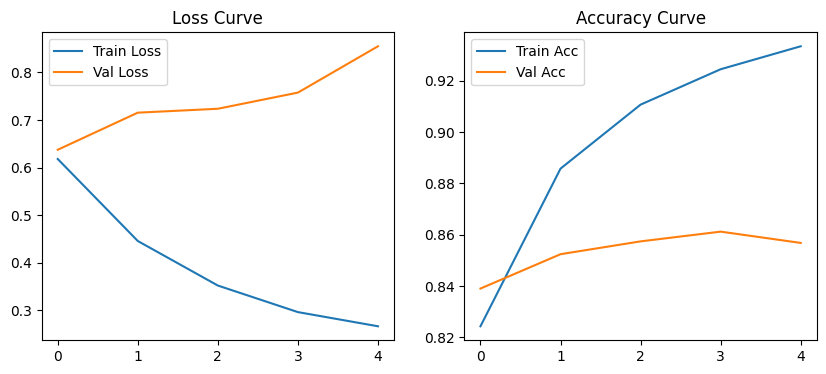

In [ ]:
# loss curves

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [ ]:
model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        y_probs.extend(probs.cpu().numpy())
        preds = probs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


              precision    recall  f1-score   support

    airplane       0.82      0.94      0.88      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.87      0.75      0.80      1000
         cat       0.67      0.79      0.73      1000
        deer       0.87      0.79      0.82      1000
         dog       0.72      0.83      0.77      1000
        frog       0.87      0.91      0.89      1000
       horse       0.94      0.79      0.86      1000
        ship       0.96      0.87      0.91      1000
       truck       0.93      0.90      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



In [ ]:
import seaborn as sns

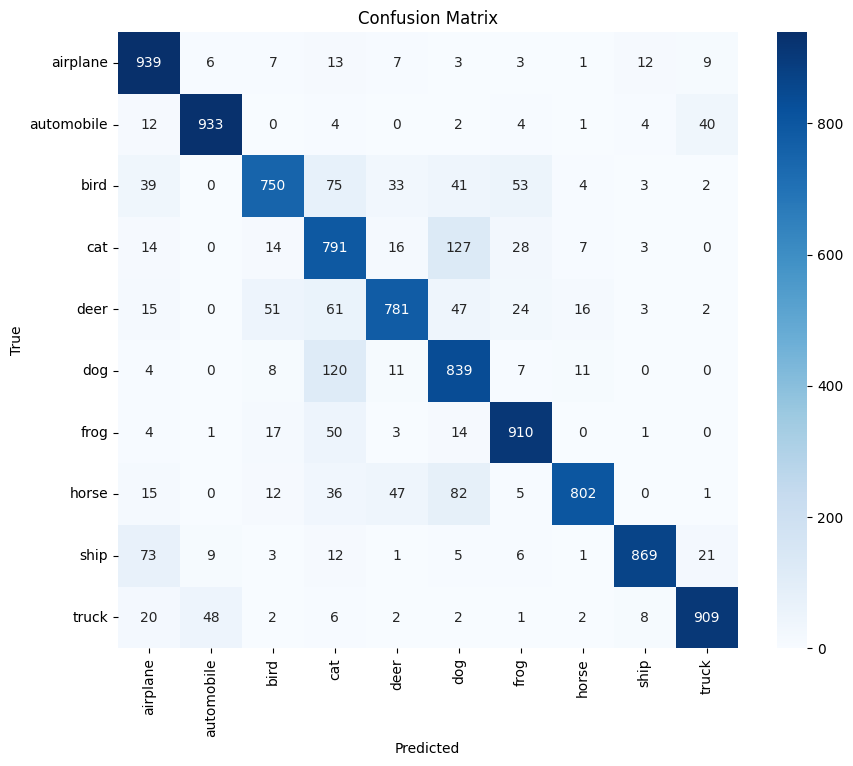

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), 'vgg19-cifar10.pth')

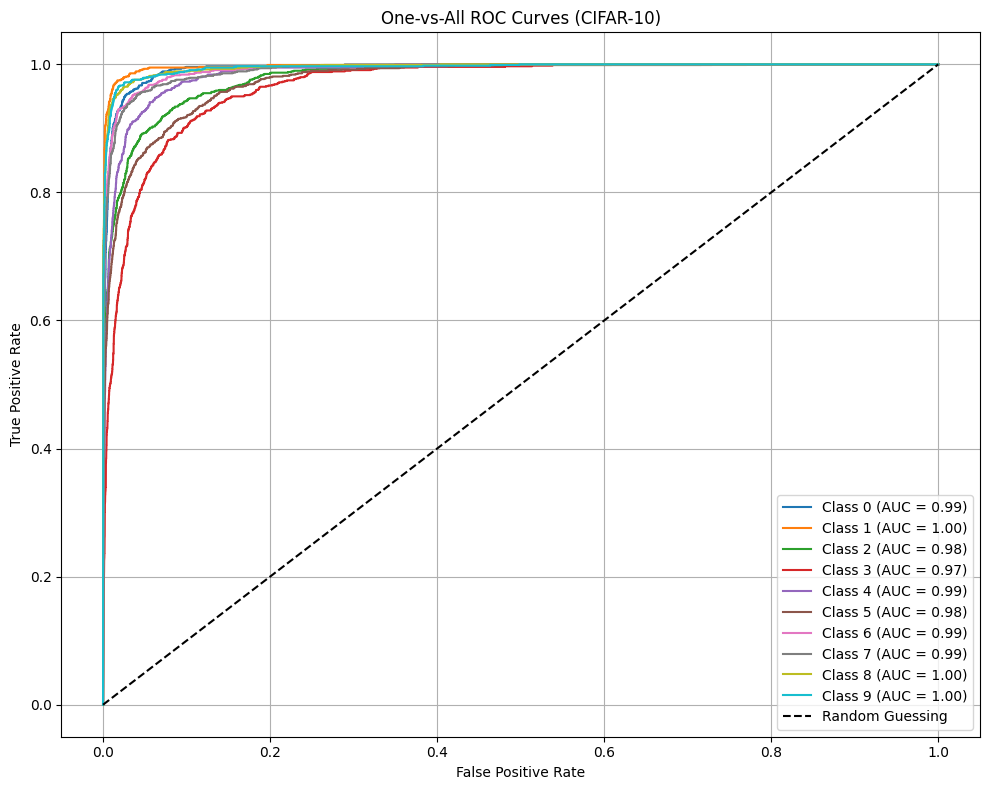

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

n_classes = 10

# Binarize labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))  # shape: (N, 10)
y_probs = np.array(y_probs)  # shape: (N, 10)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-All ROC Curves (CIFAR-10)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
